# Object Detection

Object detection is the task of identifying objects within an image and classifying the object into a class. Given the picture on the left, the model aims to output bounding boxes around objects within the image and print the classification of the object, seen in the right.

Training these models require large datasets containing images with the coordinates of the golden bounding boxes around all objects and their classes as labels. An example of this type of dataset can be seen [here](https://github.com/Shenggan/BCCD_Dataset).

![object_detection_example](https://i.imgur.com/ARmL1R3.jpg)

We use Tensorflow Hub to load a pretrained model, there are many to choose from, but the model explained below is a pretrained InceptionV2 ResNet with a FasterRCNN head.

## Faster Region-Based CNNs (FasterR-CNN)

### R-CNN 

[R-CNNs](http://islab.ulsan.ac.kr/files/announcement/513/rcnn_pami.pdf), introduced by Girshick et al., use [search selective](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf) to establish regions within an image by grouping similar pixels. These regions can be seen as the outline of definitive objects, starting from small specific outlines (someones head, neck, torso etc.) and ending with larger outline of more complete shapes (an entire human body), seen below.

![search_selective_regions](https://i.imgur.com/WpcKSk0.png)

2000 bounding boxes are then placed over combinations of these regions, seen below.

![search_selective_bboxes](https://i.imgur.com/NdSpxSU.png)

These 2000 boxes are then passed to a pretrained CNN ([AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) in the original paper) which outputs a 4096 element feature vector. This is passed to a linear SVM for classification - one SVM is trained per class. Finally, a linear regression model is trained to generate tighter bounding boxes around each identified object.

This naturally introduces an intense resource requirement, for any image, the model needs to operate over 2000 boxes for detection. Queue, FastR-RCNN

### FastR-CNN

[FastR-CNN](https://arxiv.org/pdf/1504.08083.pdf) lightens the requirement by passing the image to a CNN once, not 2000 times like its predecessor. The feature maps generated by the CNN are used to extract region proposals - again, search selective is used. These proposals are passed to a RoI (Region of Interest) pooling layer for resizing to a fixed shape. 

The RoI pooling accepts the feature maps together with N X 5 matrix representing a list of proposals, where N is the number of proposals. The matrix contains the image index and the coordiantes of the vertices of the region. The RoI layer then selects a section of the input feature map corresponding to the region and scales it to a predefined size. Scaling is performed as such:

  1. Each proposal is divided into equal sections - the number of sections corresponds to the dimension of the output.
  2. The max of the values in each section is taken - standard max pooling.
  3. Each max value is copied to the output buffer.

This results in a list of corresponding feature maps with a fixed size from a list of rectangles. This process is shown in the gif below.

![roi_pooling_gif](https://deepsense.ai/wp-content/uploads/2017/02/roi_pooling-1.gif)

The RoI outputs are then passed to a fully connected network with a softmax and linear regression layer (in parallel) on the head. The softmax naturally classifies the regions into classes, whilst the regression layer outputs the bounding box coordinates for the predictions.

This makes the FastR-CNN a single model, unlike the R-CNN which is made up of a CNN, Linear SVMs and a Regression model. Ultimately, whilst the FastR-CNN is quicker than the R-CNN (no suprise there), it still relies on search selective which is time consuming (search selective is cpu based). To fix these issues and allow the model to scale to large real-life datasets, FasterR-CNN was proposed...

### FasterR-CNN (FRCNN)

The [FRCNN](https://papers.nips.cc/paper/5638-faster-r-cnn-towards-real-time-object-detection-with-region-proposal-networks.pdf) abandons search selective for generating proposals and instead uses a [Region Proposal Network](https://) (RPN).

Identical to the FastR-CNN, the FRCNN initally passes the image to a CNN for feature extraction. These output feature maps are then passed to a RPN.

The RPN receives the feature maps and slides a fixed-size window over the maps - much like a filter slides over an input for convolution. At each window slide, the RPN generates $k$ anchor boxes of varying area and aspect ratios, effectively proposing regions of interest.  

These proposals are passed to an intermediate layer prior to being passed to a classification layer and a regression layer. The classification layer predicts the probability that each anchor is an object - it is not classifying the object class! The regression layer adjusts the coordinates of the anchors. This process is seen below:

![rpn_example](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/0n6pZEyvW47nlcdQz.png)

These adjusted anchors are again fed to a RoI pooling layer to extracted fixed-size feature maps for each anchor. These final feature maps are passed to a fully-connected network with a softmax and regression layer at the head to classify the object and predict the bounding boxes.

The weights of the initial CNN are shared between the RPN and the detector (FastR-CNN is the detector for the FRCNN), a 4 step training method was proposed:

  1. The RPN is first trained independently, with the initial CNN initialized with weights from an ImageNet pretrained network, and is then fine-tuned for the region proposal task.
  2. The FastR-CNN (detector) is also trained independetly, with the backbone CNN again being initialized with ImageNet weights before being fine-tuned for object detection. During this, the RPN weights are fixed and the proposals from the RPN are used to train the FRCNN.
  3. The RPN is then reinitialized with weights from the above FRCNN and fine-tuned for region proposal (again). However, only layers unique to the RPN are fine-tuned (i.e all common layers are frozen). This forms the final RPN.
  4. Finally, using the final RPN, the FastR-CNN detector is fine-tuned for object detection. Identical to the above, only layers unique to the FastR-CNN are fine-tuned. This results in a FRCNN framework having shared convolution layers.

The use of an RPN over search selective results in much quicker detection times: a VGG RPN requires 198ms compared to the 1800ms required by Search Selective. However, the model is still not without its flaws.

The model is still focusing on regions of the image, not looking at the complete image. This results in many passes through a single image to extract multiple objects. In recent times, this issue has been overcome by the YOLO network (You Only Look Once), and results in a model demonstrating impeccable speed. 

The YOLO network obtains similar performance as FRCNN on most images, but does not perform well on smaller objects.









## Loading a Model for Detection

With the above theory out the way, we are now ready to load an FRCNN and perform some object detection!



In [1]:
%tensorflow_version 2.x

from tensorflow import float32, image, io, newaxis
from tensorflow_hub import load

import matplotlib.pyplot as plt

from io import BytesIO
import numpy as np
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps
from tempfile import mkstemp
from requests import get



TensorFlow 2.x selected.


We first need to define some helper functions.

`display_image` simply plots an image.

`download_and_resize` accepts an image url to download and optional width and height arguments to resize the image to.

`draw_bounding_box` accepts an image, and the coordinates of a bounding box with its classification string, and outputs the image overlayed with a bounding box.

`draw_boxes` iterates over all the objects detected in the image, selects those above a minimum confidence and calls `draw_bounding_box` for each detected object.

In [0]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize(url, width=None,  height=None, display=False):
  # Download image data
  image_data = get(url).content
  
  # Makes a temporary file for us, so we don't need to assign a filename when
  # processing/downloading multiple images
  _, filename = mkstemp(suffix=".jpg")

  # Process bytes 
  image_data = BytesIO(image_data)
  # Create a PIL image
  image = Image.open(image_data)
  # Resize with antialiasing
  if width and height:
    image = ImageOps.fit(image, (width, height), Image.ANTIALIAS)
  # Convert to RGB
  rgb_image = image.convert("RGB") 
  # Save
  rgb_image.save(filename, format="JPEG", quality=90)

  if display:
    display_image(image)
  return filename


def draw_bounding_box(image, ymin, xmin, ymax, xmax, color, font, 
                               thickness = 4, display_str=""):
  
  """Adds a bounding box to an image."""
  # Draw image for overlaying boxes on
  draw = ImageDraw.Draw(image)
  # Get the w and h of image for bounding box calculations
  im_width, im_height = image.size
  # Bounding box vertices are returned as a (ymin, xmin, ymax, xmax) tuple 
  # corresponding to the percentage of width (x) and height(y) of the image.
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  # Draw bounding box
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)], width=thickness, fill=color)
    
  # Get ID string height
  display_str_heights = font.getsize(display_str)[1] 

  # Add top & bottom margin of 0.05x
  total_display_str_height = (1 + 2 * 0.05) * display_str_heights 
  # Check if display string falls off the top of image, if so, display the 
  # string underneath bounding box
  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Get ID string height & width
  text_width, text_height = font.getsize(display_str)
  margin = np.ceil(0.05 * text_height)

  # Draw rectangle for text overlay
  draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
  # Draw ID string
  draw.text((left + margin, text_bottom - text_height - margin),
              display_str, fill="black", font=font)


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """
  Overlay labeled boxes on an image with formatted scores and label names.
  image: image to overlay
  boxes: list of bounding boxes of detected objects
  class_names: list of strings for detected objects
  max_boxes: max number of boxes to draw
  min_score: minimum confidence to draw a box around an object
  """
  # Get list of colors
  colors = list(ImageColor.colormap.values())
  # Load font
  font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)

  # Only draw the specified number of boxes
  for i in range(min(boxes.shape[0], max_boxes)):
    # Only draw bounding box around confident detections
    if scores[i] >= min_score:
      # Get bounding box x,y values
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      # Get ID string
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      
      # Different color for each class - hash of the ID str just ensures
      # each class gets its own color
      color = colors[hash(class_names[i]) % len(colors)]
      # Create PIL image 
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box(image_pil, ymin, xmin, ymax, xmax, color, 
                        font,display_str=display_str)
      # Copy values from image_pil array to image array
      np.copyto(image, np.array(image_pil))
  # Return image so we may sequentially draw each bounding box
  return image



Let us now download an image.

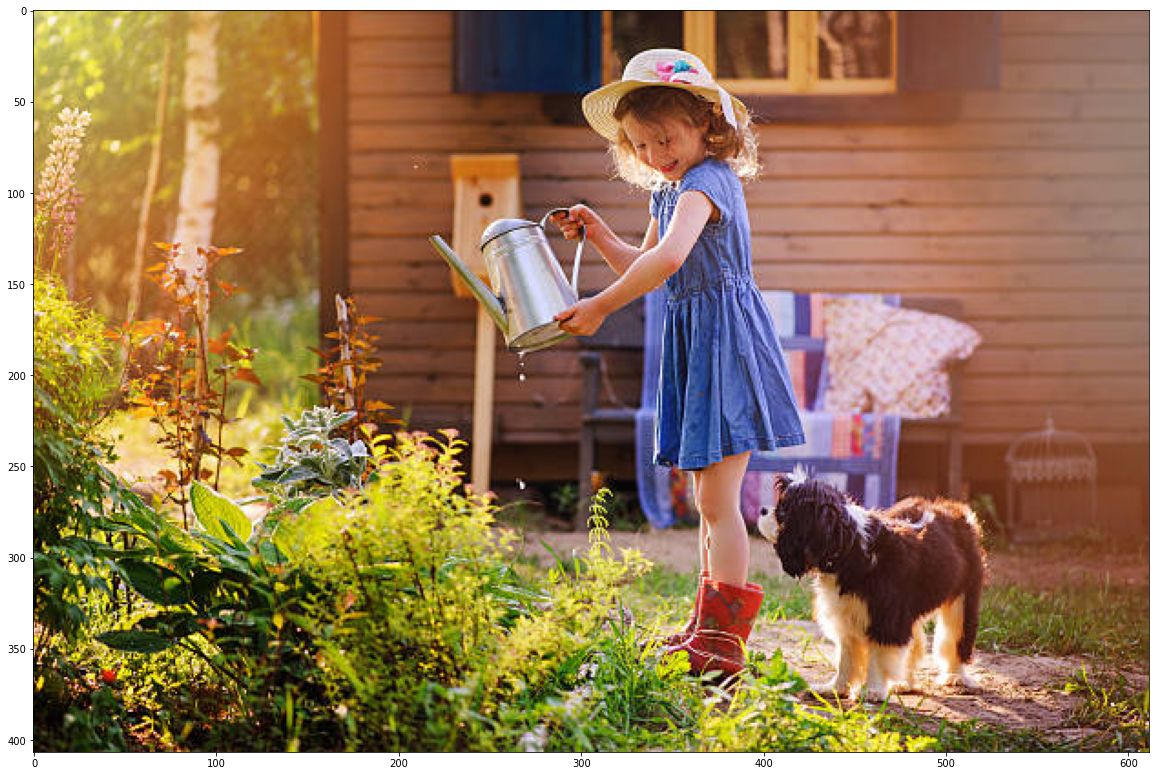

In [3]:
image_url = "https://media.gettyimages.com/photos/child-girl-watering-flowers-with-her-dog-in-summer-garden-picture-id501785588?b=1&k=6&m=501785588&s=612x612&w=0&h=jmp7VUtYzlH1MQwF6DbeFjLigY4smGrDcwYWBdsz3CM=" 
img_path = download_and_resize(image_url, display = True)

We now load the pretrained model from TF Hub, there are plenty to choose from, but check their expected inputs on the model's hub page. Some models support batching, some don't, some require normalized inputs etc.

In [4]:
model_link = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
model = load(model_link).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


We now define two helper functions to load images and run the detector on the loaded image.

In [0]:
def load_img(path):
  # Function to load images from path
  img = io.read_file(path)
  img = image.decode_jpeg(img, channels=3)
  return img

In [0]:
def run_detector(model, path):
  img = load_img(path)
  # Convert image to float32 and add dimension
  converted_img  = image.convert_image_dtype(img, float32)[newaxis, ...]
  # Pass image to pretrained model
  result = model(converted_img)
  # Pretrained model outputs can be viewed on their Hub page
  result = {key:value.numpy() for key,value in result.items()}

  # Draw boxes on image
  boxed_image = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"],
      max_boxes=10,
      min_score=0.1)
  
  display_image(boxed_image)

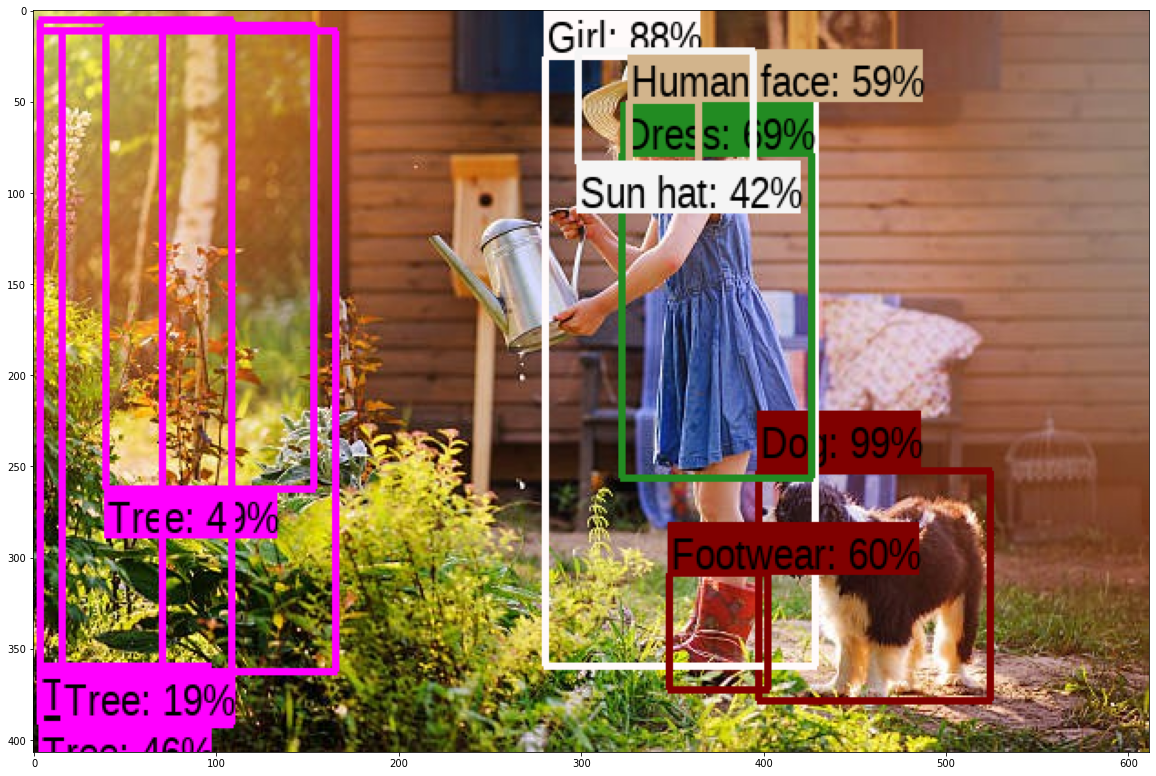

In [7]:
run_detector(model, img_path)